### 1. Import libary

In [234]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

### 2. Build data loading function

2.1 Define Paths to Files

In [235]:
# Define certain file locations for testing
BUS = os.path.join('Data', 'Bus', 'Bus (1).wav')
TRAM = os.path.join('Data', 'Tram', 'Tram (1).wav')

In [236]:
BUS

'Data\\Bus\\Bus (1).wav'

2.2 Build data loading funtion

In [237]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from sample_rate to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2.3 Plot wave

In [238]:
bus_w = load_wav_16k_mono(BUS)
tram_w = load_wav_16k_mono(TRAM)

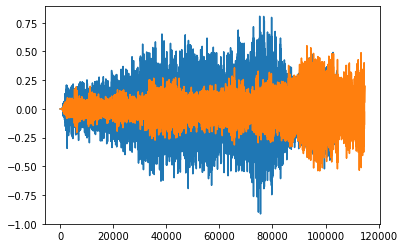

In [239]:
plt.plot(tram_w)
plt.plot(bus_w)
plt.show()

### 3. Create tensorflow dataset

3.1 Define path to data (Positive and negative)


In [240]:
# Using BUS as postive data and TRAM as negative data
POS = os.path.join('Data','Bus')
NEG = os.path.join('Data','Tram')

3.2 Create tensor flow data set

In [241]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [242]:
len(pos)

273

In [243]:
len(neg)

389

3.3 Add label and combined negative and postive dataset

In [244]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [245]:
data.shuffle(1000).as_numpy_iterator().next()

(b'Data\\Bus\\Bus (109).wav', 1.0)

### 4. Determine average length

4.1 Calculate wave cylcle length

In [246]:
lengths = []
for file in os.listdir(os.path.join('Data', 'Bus')):
    # print(file)
    tensor_wave = load_wav_16k_mono(os.path.join('Data', 'Bus', file))
    lengths.append(len(tensor_wave))

4.2 Calculate MIN MAX MEAN

In [247]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=92770>

In [248]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=291840>

In [249]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=50517>

### 5. Build preprocessing function to Convert to Spectrogram

5.1 Preprocessing funtion

In [250]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [251]:
import tensorflow as tf

def preprocess_mel_spectrogram_main(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:92000]
    zero_padding = tf.zeros([92000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    stft = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(stft)
    
    # Convert linear spectrogram to Mel spectrogram
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=257,
        sample_rate=16000,
        lower_edge_hertz=0,
        upper_edge_hertz=8000
    )
    mel_spectrogram = tf.matmul(tf.square(spectrogram), mel_filterbank)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    
    return mel_spectrogram, label

In [252]:
wav = load_wav_16k_mono(BUS)
wav


<tf.Tensor: shape=(114688,), dtype=float32, numpy=
array([ 0.0000000e+00, -2.3574648e-10,  3.2244460e-10, ...,
        1.6666979e-01,  1.8408774e-01,  2.0094502e-01], dtype=float32)>

5.2 Test out function

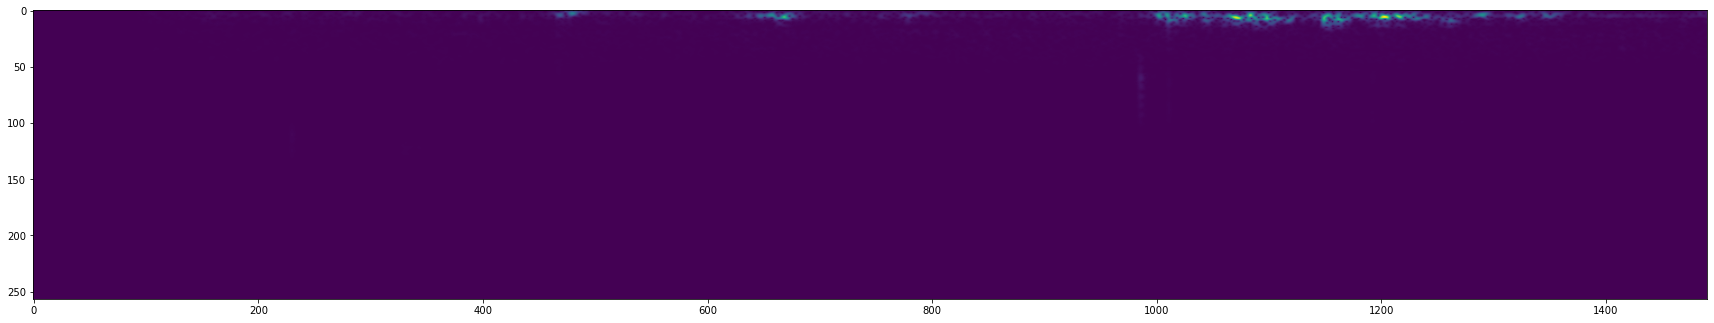

In [253]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### 6. Create Training and Testing Partitions

6.1 Create tensorflow data pipeline

In [254]:
data = data.map(preprocess_mel_spectrogram_main)
data = data.cache()
data = data.shuffle(buffer_size=1000)   
data = data.batch(16)
data = data.prefetch(8)

6.2 Split into training and testing patition

In [255]:
len(data)*.7

29.4

In [256]:
train = data.take(29)
test = data.skip(29).take(12)

6.3 Test one batch:

In [257]:
samples, labels = train.as_numpy_iterator().next()

In [258]:
samples.shape

(16, 2866, 128, 1)

### 7. Build model

7.1 Load tensor flow dependencies

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D


7.2 Build Model, complie and view sumary

In [279]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(2866, 128, 1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flatten layer
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [280]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [281]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 2864, 126, 16)     160       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 954, 42, 16)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 952, 40, 16)       2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 317, 13, 16)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 65936)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8439936   
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

7.3 Fit model, View loss and KPI plots

In [282]:
hist = model.fit(train, epochs=4, validation_data = test)

Epoch 1/4
29/29 [==============================] - 38s 1s/step - loss: 5.6258 - recall_11: 0.6461 - precision_11: 0.7516 - val_loss: 0.5299 - val_recall_11: 0.8108 - val_precision_11: 0.8108
Epoch 2/4
29/29 [==============================] - 43s 1s/step - loss: 0.4755 - recall_11: 0.8564 - precision_11: 0.8029 - val_loss: 0.2881 - val_recall_11: 0.8625 - val_precision_11: 0.9079
Epoch 3/4
29/29 [==============================] - 45s 2s/step - loss: 0.2659 - recall_11: 0.8984 - precision_11: 0.9081 - val_loss: 0.1920 - val_recall_11: 0.9765 - val_precision_11: 0.9222
Epoch 4/4
29/29 [==============================] - 41s 1s/step - loss: 0.1822 - recall_11: 0.9648 - precision_11: 0.9057 - val_loss: 0.1227 - val_recall_11: 0.9500 - val_precision_11: 0.9620


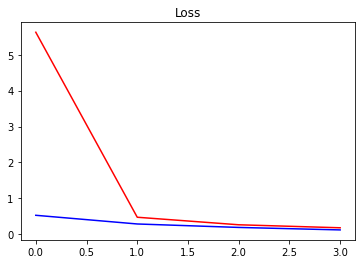

In [283]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

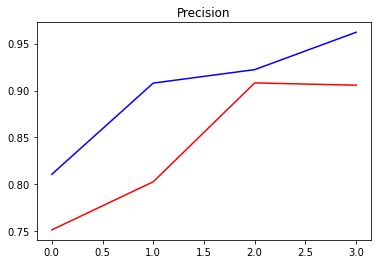

In [286]:
plt.title('Precision')
plt.plot(hist.history['precision_11'], 'r')
plt.plot(hist.history['val_precision_11'], 'b')
plt.show()

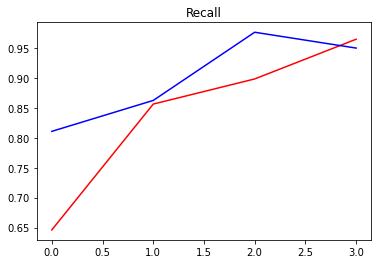

In [285]:
plt.title('Recall')
plt.plot(hist.history['recall_11'], 'r')
plt.plot(hist.history['val_recall_11'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

8.1 Get One Batch and Make a Prediction

In [287]:
x_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(x_test)
# yhat


8.2 Convert Logits to Classes 

In [288]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

tf.math.reduce_sum(yhat)



<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [289]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [305]:
evaluation_results = []

for x_test, y_test in test.as_numpy_iterator():
    # Evaluate the model on the test data
    evaluation = model.evaluate(x_test, y_test)
    
    # Append evaluation result to the list
    evaluation_results.append(evaluation[2])  # Assuming the evaluation result is a tuple (loss, accuracy), taking the loss value

    # Print the test loss and accuracy
    print(f'Test Loss: {evaluation[0]}')

# Calculate the mean of evaluation results
mean_evaluation = sum(evaluation_results) / len(evaluation_results)
print(f'Mean Evaluation: {mean_evaluation}')


1/1 [==============================] - 0s 165ms/step - loss: 0.0794 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.07943633198738098
1/1 [==============================] - 0s 171ms/step - loss: 0.1593 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.15925970673561096
1/1 [==============================] - 0s 163ms/step - loss: 0.1026 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.10262840986251831
1/1 [==============================] - 0s 171ms/step - loss: 0.1615 - recall_11: 1.0000 - precision_11: 0.9000
Test Loss: 0.16152948141098022
1/1 [==============================] - 0s 196ms/step - loss: 0.0900 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.09003802388906479
1/1 [==============================] - 0s 211ms/step - loss: 0.1606 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.16062280535697937
1/1 [==============================] - 0s 204ms/step - loss: 0.1115 - recall_11: 1.0000 - precision_11: 1.0000
Test Loss: 0.11149687319993973
1/1 [=

In [298]:
print(precision_arr) 

[[0.7516340017318726, 0.8028846383094788, 0.908108115196228, 0.9056603908538818]]


Helper code

In [ ]:
from pydub import AudioSegment
import os

def convert_to_16bit(input_dir, output_dir):
    # Function to convert files to 16-bit
    def convert_file(input_file, output_file):
        sound = AudioSegment.from_file(input_file)
        sound = sound.set_sample_width(2)  # 16-bit
        sound.export(output_file, format="wav")

    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".wav"):
            input_file_path = os.path.join(input_dir, filename)
            output_file_path = os.path.join(output_dir, filename)
            convert_file(input_file_path, output_file_path)

# Example usage:
# input_directory = r'path_to_input_directory'
# output_directory = r'path_to_output_directory'

# convert_to_16bit(input_directory, output_directory)
